# Introduction

The Ugrainium recipe uses groupings of ingredients to try to cover nutritional requirements with enough overlap that a single ingredient with quality issues does not cause a failure for the whole recipe. A opimizer is used to find the right amount of each ingredient to fulfill the nutritional and practicle requirements for a recipe.

# To Do

* Nutrients without an upper limit should have the upper limit constraint removed
* Add constraints for the NIH essential protein combinations as a limit
* Add a radar graph for vitamins showing the boundry between RDI and UL
* Add a radar graph for vitamins without an upper limit but showing the RDI
* Add a radar graph for essential proteins showing the range between RDI and UL
* Add a radar graph for essential proteins without an upper limit, but showing the RDI as the lower limit
* Add a radar graph pair for non-essential proteins with the above UL and no UL pairing
* Add equality constraints for at least energy, and macro nutrients if possible

In [21]:
# Import all of the helper libraries 

from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import least_squares, lsq_linear
import pandas as pd
import numpy as np
import os
import json
import requests
from math import e
import matplotlib.pyplot as plt
import seaborn as sns
from math import log10
from ipysheet import from_dataframe, to_dataframe
#%matplotlib inline

In [2]:
#!pip install seaborn
#!pip install ipysheet
#!pip install ipywidgets

In [3]:
# Setup the notebook context

data_dir = '../data'
pd.set_option('max_columns', 70)


# Our Data

The [tables](https://docs.google.com/spreadsheets/d/1UOx5ZkNMjcwybx9TgFS_EaQnjbokqDx6K9NW0mRDGlg/edit#gid=6244197120) containing our ingredients nutrition profile are held in Google Sheets.
The sheet names are "Ingredients" and "Nutrition Profile"


In [4]:
# Download our nutrition profile data from Google Sheets
!(cd ..; make sync_data_from_google)

nutrition_profile_df = pd.read_csv(f'{data_dir}/raw/nutrition_profile.csv', index_col=0, verbose=True).transpose()
ingredients_df = pd.read_csv(f'{data_dir}/raw/ingredients.csv', index_col=0, verbose=True).transpose()

# convert all values to float
for col in ingredients_df.columns:
    ingredients_df[col] = ingredients_df[col].astype(float)

#sheet = from_dataframe(ingredients_df)
#sheet

curl -L 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRYlsZPuEL1r700-ID0Arkf9M3mg4GmKt-g1NqhvXj-tc5rWxnAsGj6PHp2gT958-x6LZgrS_-XmJDt/pub?gid=624419712&single=true&output=csv' > data/raw/nutrition_profile.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   460    0   460    0     0    652      0 --:--:-- --:--:-- --:--:--   651
100  3424    0  3424    0     0   1300      0 --:--:--  0:00:02 --:--:--  4898
curl -L 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRYlsZPuEL1r700-ID0Arkf9M3mg4GmKt-g1NqhvXj-tc5rWxnAsGj6PHp2gT958-x6LZgrS_-XmJDt/pub?gid=1812860789&single=true&output=csv' > data/raw/ingredients.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   461    0   461    0     0   1396      0 --:--:-- --:--:-- --:--:--  1396
100  5137    0  5137    0   

In [5]:
ingredients_df

,Calories (kcal),Carbohydrates (g),Protein (g),Total Fat (g),Saturated Fat (g),Monounsaturated Fat (g),Polyunsaturated Fat (g),Omega-3 Fatty Acids (g),Omega-6 Fatty Acids (g),Total Fiber (g),Soluble Fiber (g),Insoluble Fiber (g),Cholesterol (mg),Vitamin A (IU),Vitamin B6 (mg),Vitamin B12 (ug),Vitamin C (mg),Vitamin D (IU),Vitamin E (IU),Vitamin K (ug),Thiamin (mg),Riboflavin (mg),Niacin (mg),Folate (ug),Pantothenic Acid (mg),Biotin (ug),Choline (mg),Calcium (g),Chloride (g),Chromium (ug),Copper (mg),Iodine (ug),Iron (mg),Magnesium (mg),Manganese (mg),Molybdenum (ug),Phosphorus (g),Potassium (g),Selenium (ug),Sodium (g),Sulfur (g),Zinc (mg),Cystine (mg),Histidine (mg),Isoleucine (mg),Leucine (mg),Lysine (mg),Methionine (mg),Phenylalanine (mg),Threonine (mg),Tryptophan (mg),Valine (mg),Tyrosine (mg),Arginine (mg),Alanine (mg),Aspartic acid (mg),Glutamic acid (mg),Glycine (mg),Proline (mg),Serine (mg),Hydroxyproline (mg)
Guar gum,332.0,77.30,4.60,0.50,0.060,0.220,0.070,0.001,0.067,77.3,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.294,0.000,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.000,0.000,0.0,0.125,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Vitamin K,0.0,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,500.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Peanut butter,597.0,22.30,22.50,51.10,10.100,25.400,12.300,0.000,3.830,4.8,1.44,3.36,0.0,0.0,0.444,0.0,0.0,0.0,6.104,0.3,0.138,0.191,13.300,86.0,0.000,0.0,63.0,0.049,0.000,0.0,0.420,0.0,1.73,169.0,0.000,0.0,339.000,564.000,4.1,0.429,0.000,2.54,331.0,652.0,907.0,1672.0,926.0,317.0,1337.0,883.0,250.0,1082.0,1049.0,3085.0,1025.0,3146.0,5390.0,1554.0,1138.0,1271.0,0.0
Oat flour,400.0,65.00,17.50,7.50,1.600,2.900,3.300,0.145,3.185,10.0,4.00,6.00,0.0,0.0,0.125,0.0,0.0,0.0,1.000,3.2,0.700,0.125,1.500,32.0,0.200,0.0,29.9,0.065,0.000,0.0,0.437,0.0,4.00,144.0,4.000,0.0,0.452,0.371,34.0,0.019,0.000,3.20,408.0,405.0,694.0,1284.0,701.0,312.0,895.0,575.0,234.0,937.0,564.0,1179.0,872.0,1436.0,3718.0,846.0,923.0,744.0,0.0
Choline Bitartrate,0.0,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,550.0,0.000,0.000,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Wheat bran, crude",216.0,64.51,15.55,4.25,0.630,0.637,2.212,0.167,2.039,42.8,0.00,42.80,0.0,9.0,1.303,0.0,0.0,0.0,1.490,1.9,0.523,0.577,13.578,79.0,2.181,0.0,74.4,0.073,0.000,0.0,0.998,0.0,10.57,611.0,2.000,0.0,1.013,1.182,77.6,0.002,0.605,7.27,371.0,430.0,486.0,928.0,600.0,234.0,595.0,500.0,282.0,726.0,436.0,1087.0,765.0,1130.0,2874.0,898.0,882.0,684.0,0.0
Lecithin granules,700.0,10.00,0.00,50.00,15.000,0.000,35.000,0.000,0.000,0.0,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,13000.0,0.200,0.000,0.0,0.000,0.0,3.60,0.0,0.000,0.0,3.000,1.600,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alpha-galactosidase enzyme (Beano),0.0,0.00,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Canola oil,884.0,0.00,0.00,100.00,7.365,63.276,28.142,9.137,19.005,0.0,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,17.460,71.3,0.000,0.000,0.000,0.0,0.000,0.0,0.2,0.000,0.000,0.0,0.000,0.0,0.00,0.0,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pea Protein Powder,375.0,1.00,82.10,7.14,3.570,0.000,0.000,0.000,0.000,0.5,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0

To install ipysheet, the following commands need to be run:
- conda install ipywidgets
- jupyter labextension install @jupyter-widgets/jupyterlab-manager
see: https://stackoverflow.com/questions/36351109/ipython-notebook-ipywidgets-does-not-show

In [6]:
from ipysheet import sheet, cell, row, column, cell_range
from ipywidgets import interact, interactive, fixed, interact_manual
sheet1 = sheet(rows=3, columns=4)
display(sheet1)

Sheet(layout=Layout(height='auto', width='auto'))

ingredient_map = {
    'wheat bran': '785757',
    'oat flour': '169741',
    'corn flour': '169694',
    'whey protein isolate': '173177',
    'soy protein isolate': '174276',
    'lecithin': '171426',
    'canola oil': '172336',
    'barley flour': '169739',
    'flaxseed': '169414',
    'guar gum': '169045',
    'xanthan gum': '563344',
}

def get_fdc(fdc_id):
    key = 'ranhDhgRXsjucJQHSk9zMeX2XSS02iUQvzDBAvpG'
    payload={'api_key': key}
    url = f'https://api.nal.usda.gov/fdc/v1/food/{fdc_id}'
    r = requests.get(url, params=payload)
    def nutrient_decode(el):
        if 'nutrient' in el:
            if 'amount' in el:
                return((f'{el["nutrient"]["name"]} ({el["nutrient"]["unitName"]})', el['amount']))
            else:
                return(None)
        return(el)
    print(f'result: {r}')
    res = json.loads(r.text, object_hook=nutrient_decode)
    return pd.Series(dict(filter(lambda el: el is not None, res['foodNutrients'])), name=res['description'])
    
ing_list = []
for (ing_name, fdc_id) in ingredient_map.items():
    ing_list.append(get_fdc(fdc_id))
ing_df = pd.DataFrame(ing_list)


In [7]:
ing_df = ingredients_df
print(str(sorted(ing_df.columns)))

['Alanine (mg)', 'Arginine (mg)', 'Aspartic acid (mg)', 'Biotin (ug)', 'Calcium (g)', 'Calories (kcal)', 'Carbohydrates (g)', 'Chloride (g)', 'Cholesterol (mg)', 'Choline (mg)', 'Chromium (ug)', 'Copper (mg)', 'Cystine (mg)', 'Folate (ug)', 'Glutamic acid (mg)', 'Glycine (mg)', 'Histidine (mg)', 'Hydroxyproline (mg)', 'Insoluble Fiber (g)', 'Iodine (ug)', 'Iron (mg)', 'Isoleucine (mg)', 'Leucine (mg)', 'Lysine (mg)', 'Magnesium (mg)', 'Manganese (mg)', 'Methionine (mg)', 'Molybdenum (ug)', 'Monounsaturated Fat (g)', 'Niacin (mg)', 'Omega-3 Fatty Acids (g)', 'Omega-6 Fatty Acids (g)', 'Pantothenic Acid (mg)', 'Phenylalanine (mg)', 'Phosphorus (g)', 'Polyunsaturated Fat (g)', 'Potassium (g)', 'Proline (mg)', 'Protein (g)', 'Riboflavin (mg)', 'Saturated Fat (g)', 'Selenium (ug)', 'Serine (mg)', 'Sodium (g)', 'Soluble Fiber (g)', 'Sulfur (g)', 'Thiamin (mg)', 'Threonine (mg)', 'Total Fat (g)', 'Total Fiber (g)', 'Tryptophan (mg)', 'Tyrosine (mg)', 'Valine (mg)', 'Vitamin A (IU)', 'Vitamin 

In [8]:
d = {'a':'b'}
d.items()
l = [d]
list(d.keys())[0]
tuple(d)
tuple(d.items())

(('a', 'b'),)

# Problem Setup

Let's cast our data into the from $\vec{y} = A \vec{x} + \vec{b}$ where $A$ is our ingredients data, $\vec{x}$ is the quantity of each ingredient for our recipe, and $\vec{b}$ is the nutrition profile.
The problem to be solved is to find the quantity of each ingredient which will optimally satisfy the nutrition profile, or in our model, to minimize: $|A \vec{x} - \vec{b}|$.

There are some nutrients we only want to track, but not optimize. For example, we want to know how much cholesterol is contained in our recipe, but we don't want to constrain our result to obtain a specific amount of cholesterol as a goal. The full list of ingredients are named: A_full, and b_full. The values to optimized are named: A and b

In [43]:
b_full = nutrition_profile_df
A_full = ingredients_df.transpose()
A = ingredients_df.transpose()[nutrition_profile_df.loc['Report Only'] == False]

b_full = nutrition_profile_df.loc['Target']
b = nutrition_profile_df.loc['Target'][nutrition_profile_df.loc['Report Only'] == False]
ul = nutrition_profile_df.loc['UL'][nutrition_profile_df.loc['Report Only'] == False]
rdi = nutrition_profile_df.loc['RDI'][nutrition_profile_df.loc['Report Only'] == False]
weight = nutrition_profile_df.loc['Weight'][nutrition_profile_df.loc['Report Only'] == False]
ul_full = nutrition_profile_df.loc['UL']
rdi_full = nutrition_profile_df.loc['RDI']

In [9]:
#weight

Calories (kcal)            100.0
Carbohydrates (g)          100.0
Protein (g)                100.0
Total Fat (g)              100.0
Omega-3 Fatty Acids (g)      1.0
Omega-6 Fatty Acids (g)      1.0
Total Fiber (g)             10.0
Soluble Fiber (g)            1.0
Insoluble Fiber (g)         10.0
Vitamin A (IU)               1.0
Vitamin B6 (mg)              1.0
Vitamin B12 (ug)             1.0
Vitamin C (mg)               1.0
Vitamin D (IU)               1.0
Vitamin E (IU)               1.0
Vitamin K (ug)               1.0
Thiamin (mg)                 1.0
Riboflavin (mg)              1.0
Niacin (mg)                  1.0
Folate (ug)                  1.0
Pantothenic Acid (mg)        1.0
Biotin (ug)                  1.0
Choline (mg)                 1.0
Calcium (g)                  1.0
Chloride (g)                 1.0
Chromium (ug)                1.0
Copper (mg)                  1.0
Iodine (ug)                  1.0
Iron (mg)                    1.0
Magnesium (mg)               1.0
Manganese 

# Least Squares Optimization
Start with a simple solver using a least squares optimizer


In [18]:
# Using the scipy least_squares optimizer
# Define a residual function: if y = A x + b -> A x - b is the residual function
k_thres = 0.7
k_rdi = b - ((rdi - b) * k_thres)
k_ul =  b + ((ul - b) * k_thres)

def limit_scale(df):
    r = ((df['y'] - df['b']) /  df['b']) * df['weight']
    k_thres = 0.7
    if df['y'] < df['k_rdi']:
        r *= 10
        if df['y'] < df['rdi']:
            r *= 10
    elif df['y'] >= df['b']:
        if df['k_ul'] is np.NaN:
            return(0.0)
        elif df['y'] > df['k_ul']:
            r *= 10
        if df['y'] > df['ul']:
            r *= 10
    return(r)

scale_limits = pd.DataFrame({'rdi': rdi, 'k_rdi': k_rdi, 'b': b, 'k_ul': k_ul, 'ul': ul, 'weight': weight})

def residuals(x, *args, **kwargs):
    y0 = A.dot(x.transpose())
    res0 = pd.concat([scale_limits, pd.Series(y0,scale_limits.index, name='y')], axis=1)
    res1 = res0.apply(limit_scale, axis=1)
    #print(f'x: {x}, residual: {res1}')
    return(res1)

In [44]:
# Constrain ingredients before the optimization process. Many of the ingredients are required for non-nutritional purposes 
# or are being limited to enhance flavor
#
# The bounds units are in fractions of 100g / day, i.e.: 0.5 represents 50g / day, of the ingredient

bounds_df = pd.DataFrame(index=ingredients_df.index, data={'lower': 0, 'upper': np.inf})             
bounds_df.loc['Guar gum'] = [1.0 * .01, 1.0 * .01 + .0001]
bounds_df.loc['Xanthan Gum'] = [1.0 * .01, 1.0 * .01 + .0001]
bounds_df.loc['Alpha-galactosidase enzyme (Beano)'] = [1.0, 1.0 + .0001]
bounds_df.loc['Multivitamin'] = [1.0, 1.0 + .0001]
bounds_df.loc['Corn flour, nixtamalized'] = [0, 1.0]
bounds_df.loc['Whey protein'] = [0,0.15]
bounds_df.loc['Ascorbic acid'] = [0.01, 0.01 + .0001]
bounds_df.loc['Peanut butter'] = [0.25, 0.50]
lower = list(bounds_df.lower.values)
upper = list(bounds_df.upper.values)

# x0 is our initial guess at a solution
x0 = np.array(lower)

len(lower), len(upper), x0

(21,
 21,
 array([0.01, 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 1.  ,
        0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ]))

In [19]:
solution = least_squares(residuals, x0, jac='2-point', bounds=(lower, upper), method='trf', ftol=1e-08, xtol=1e-08, gtol=1e-08, x_scale=1.0, loss='linear', f_scale=1.0, diff_step=None, tr_solver=None, tr_options={}, jac_sparsity=None, max_nfev=None, verbose=1, args=(), kwargs={})
solution.success, solution.x

`xtol` termination condition is satisfied.
Function evaluations 41, initial cost 1.9007e+08, final cost 4.4664e+07, first-order optimality 1.85e+07.


(True,
 array([1.00340315e-02, 2.35768344e-04, 2.50000000e-01, 3.91327093e-01,
        1.41985559e-05, 3.43480973e-01, 2.16304030e-01, 1.00000000e+00,
        2.70279112e-01, 4.31253339e-01, 1.00000000e+00, 3.37559994e-01,
        4.58380572e-01, 1.00000001e-02, 3.95932851e-01, 5.87155506e-02,
        5.03133941e-03, 6.29226874e-05, 1.00348351e-02, 2.34767245e-03,
        2.68758542e-01]))

In [45]:
A.shape, b.shape
b

Calories (kcal)            2000.0
Carbohydrates (g)           279.0
Protein (g)                 104.0
Total Fat (g)                57.0
Omega-3 Fatty Acids (g)      14.5
Omega-6 Fatty Acids (g)      14.4
Total Fiber (g)              64.6
Soluble Fiber (g)             3.6
Insoluble Fiber (g)          60.0
Vitamin A (IU)             3600.0
Vitamin B6 (mg)               2.9
Vitamin B12 (ug)              4.1
Vitamin C (mg)              153.0
Vitamin D (IU)             1020.0
Vitamin E (IU)               34.0
Vitamin K (ug)              204.0
Thiamin (mg)                  2.0
Riboflavin (mg)               2.2
Niacin (mg)                  27.2
Folate (ug)                 680.0
Pantothenic Acid (mg)         8.5
Biotin (ug)                  30.0
Choline (mg)                935.0
Calcium (g)                   1.7
Chloride (g)                  2.3
Chromium (ug)                35.0
Copper (mg)                   0.9
Iodine (ug)                 150.0
Iron (mg)                    13.6
Magnesium (mg)

In [53]:
#solution = lsq_linear(A, b, bounds=(lower, upper), method='trf', lsq_solver='lsmr', verbose=2)
solution = lsq_linear(A, b, method='trf', lsq_solver='lsmr', verbose=2)
solution.success, solution.x

The unconstrained solution is optimal.
Final cost 1.6834e+06, first-order optimality 1.83e+04


(True,
 array([1.5883045669393505, -0.3865174805075121, -0.37439017792684226,
        1.8625117803678402, -0.18036771840519836, 6.4882585047492265,
        0.05705566913504411, 0.0, 4.8184813607772, -1.0652931482996197,
        1.392617038907126, -6.275626378949271, 2.508030856579331,
        0.0003375363223971148, 5.798198289567536, 0.1486022491023802,
        -0.24431607139157188, 1.128252446099903, 1.2723241450618437,
        1.1477564681279737, -10.148606682057366], dtype=object))

In [54]:
A_full.dot(solution.x)

Calories (kcal)         1978.014924
Carbohydrates (g)        401.159642
Protein (g)               63.739326
Total Fat (g)            136.331333
Saturated Fat (g)         -2.657299
                           ...     
Glutamic acid (mg)     19130.388989
Glycine (mg)             -44.845935
Proline (mg)           10713.589309
Serine (mg)             3068.412879
Hydroxyproline (mg)    -1648.208235
Length: 61, dtype: object

In [34]:
# Scale the ingredient nutrient amounts for the given quantity of each ingredient given by the optimizer
solution_df = A_full.transpose().mul(solution.x, axis=0) # Scale each nutrient vector per ingredient by the amount of the ingredient
solution_df.insert(0, 'Quantity (g)', solution.x * 100) # Scale to 100 g since that is basis for the nutrient quantities

# Add a row showing the sum of the scaled amount of each nutrient
total = solution_df.sum()
total.name = 'Total'
solution_df = solution_df.append(total)

<BarContainer object of 1 artists>

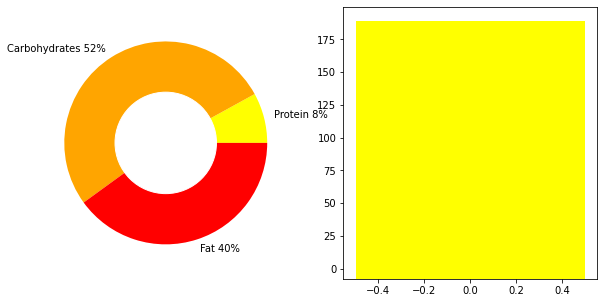

In [35]:
# Plot the macro nutrient profile
# The ratio of Calories for protein:carbohydrates:fat is 4:4:9 kcal/g
pc = solution_df['Protein (g)']['Total'] * 4.0
cc = solution_df['Carbohydrates (g)']['Total'] * 4.0
fc = solution_df['Total Fat (g)']['Total'] * 9.0
tc = pc + cc + fc
p_pct = int(round(pc / tc * 100))
c_pct = int(round(cc / tc * 100))
f_pct = int(round(fc / tc * 100))
(p_pct, c_pct, f_pct)
# create data
names=f'Protein {p_pct}%', f'Carbohydrates {c_pct}%', f'Fat {f_pct}%', 
size=[p_pct, c_pct, f_pct]
 
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1,2,1)
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.5, color='white')

# Give color names
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)
colors = ['yellow','orange','red']
plt.pie(size, labels=names, colors=colors)

#p=plt.gcf()
#p.gca().add_artist(my_circle)
fig.gca().add_artist(my_circle)
#plt.show()

fig.add_subplot(1,2,2)
barWidth = 1
fs = [solution_df['Soluble Fiber (g)']['Total']]
fi = [solution_df['Insoluble Fiber (g)']['Total']]
plt.bar([0], fs, color='red', edgecolor='white', width=barWidth)
plt.bar([0], fi, bottom=fs, color='yellow', edgecolor='white', width=barWidth, label=['Insoluble Fiber (g)'])
 
# Also show the Omega-3, Omega-6 ratio
# Saturated:Monounsaturated:Polyunsaturated ratios

In [36]:
# Prepare data as a whole for plotting by normalizing and scaling
amounts = solution_df
total = A_full.dot(solution.x) #solution_df.loc['Total']

# Normalize as a ratio beyond RDI
norm = (total) / rdi_full
norm_ul = (ul_full) / rdi_full

nuts = pd.concat([pd.Series(norm.values, name='value'), pd.Series(norm.index, name='name')], axis=1)

In [37]:
# Setup categories of nutrients and a common plotting function
vitamins = ['Vitamin A (IU)','Vitamin B6 (mg)','Vitamin B12 (ug)','Vitamin C (mg)','Vitamin D (IU)',
            'Vitamin E (IU)','Vitamin K (ug)','Thiamin (mg)','Riboflavin (mg)','Niacin (mg)','Folate (ug)','Pantothenic Acid (mg)','Biotin (ug)','Choline (mg)']
minerals = ['Calcium (g)','Chloride (g)','Chromium (ug)','Copper (mg)','Iodine (ug)','Iron (mg)',
            'Magnesium (mg)','Manganese (mg)','Molybdenum (ug)','Phosphorus (g)','Potassium (g)','Selenium (ug)','Sodium (g)','Sulfur (g)','Zinc (mg)']
essential_aminoacids = ['Cystine (mg)','Histidine (mg)','Isoleucine (mg)','Leucine (mg)','Lysine (mg)',
                        'Methionine (mg)','Phenylalanine (mg)','Threonine (mg)','Tryptophan (mg)','Valine (mg)']
other_aminoacids = ['Tyrosine (mg)','Arginine (mg)','Alanine (mg)','Aspartic acid (mg)','Glutamic acid (mg)','Glycine (mg)','Proline (mg)','Serine (mg)','Hydroxyproline (mg)']

def plot_group(nut_names, title):
    nut_names_short = [s.split(' (')[0] for s in nut_names] # Snip off the units from the nutrient names
    
    # Create a bar to indicate an upper limit 
    ul_bar = (norm_ul * 1.04)[nut_names]
    ul_bar[ul_full[nut_names].isnull() == True] = 0
    
    # Create a bar to mask the UL bar so just the end is exposed
    ul_mask = norm_ul[nut_names]
    ul_mask[ul_full[nut_names].isnull() == True] = 0
    
    
    n = []  # normalized values for each bar
    for x, mx in zip(norm[nut_names], ul_mask.values):
        if mx == 0: # no upper limit
            if x < 1.0:
                n.append(1.0 - (x / 2.0))
            else:
                n.append(0.50)
        else:
            n.append(1.0 - (log10(x) / log10(mx)))
    clrs = sm.to_rgba(n, norm=False)
    
    g = sns.barplot(x=ul_bar.values, y=nut_names_short, color='red')
    g.set_xscale('log')
    sns.barplot(x=ul_mask.values, y=nut_names_short, color='white')
    bax = sns.barplot(x=norm[nut_names], y=nut_names_short, label="Total", palette=clrs)
    
    # Add a legend and informative axis label
    g.set( ylabel="",xlabel="Nutrient Mass / RDI (Red Band is UL)", title=title)

    #sns.despine(left=True, bottom=True)

ValueError: math domain error

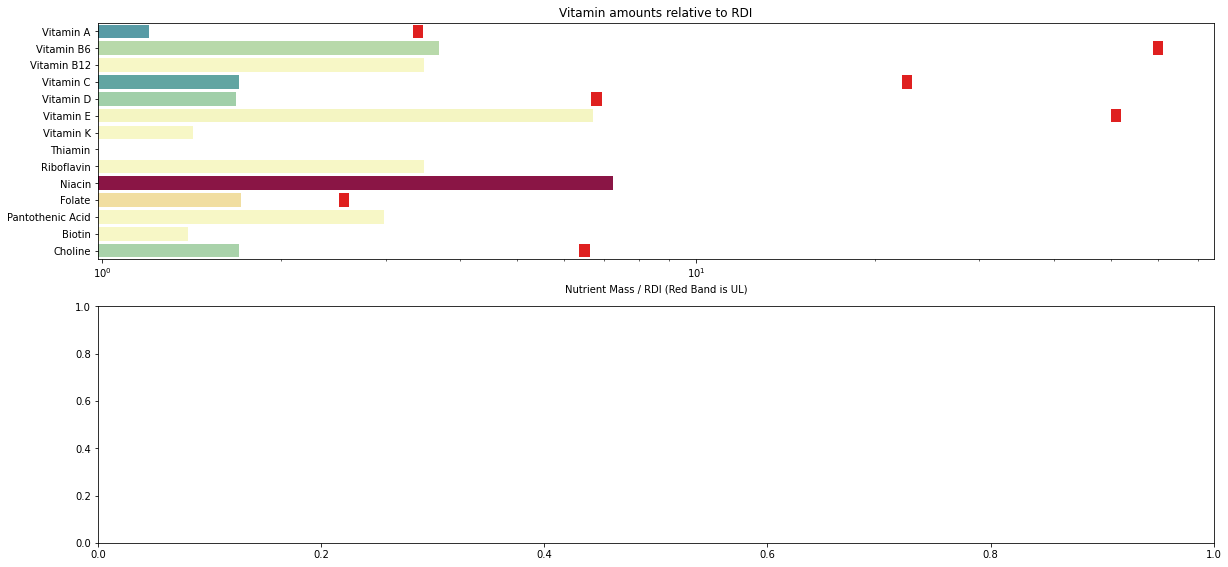

In [40]:
# Construct a group of bar charts for each nutrient group

# Setup the colormap for each bar
cmap = plt.get_cmap('Spectral')
sm = plt.cm.ScalarMappable(cmap=cmap)

#fig = plt.figure(figsize=plt.figaspect(3.))
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(4, 1, 1)
plot_group(vitamins,'Vitamin amounts relative to RDI')
fig.add_subplot(4, 1, 2)
plot_group(minerals,'Mineral amounts relative to RDI')
fig.add_subplot(4, 1, 3)
plot_group(essential_aminoacids,'Essential amino acid amounts relative to RDI')
fig.add_subplot(4, 1, 4)
plot_group(other_aminoacids,'Other amino acid amounts relative to RDI')

#fig.show()
fig.tight_layout()

In [41]:
solu_amount = solution_df['Quantity (g)']
solu_amount.index.name = 'Ingredient'
solu_amount.reset_index()

,Ingredient,Quantity (g)
0,Guar gum,158.830457
1,Vitamin K,-38.651748
2,Peanut butter,-37.439018
3,Oat flour,186.251178
4,Choline Bitartrate,-18.036772
5,"Wheat bran, crude",648.82585
6,Lecithin granules,5.705567
7,Alpha-galactosidase enzyme (Beano),0.0
8,Canola oil,481.848136
9,Pea Protein Powder,-106.529315


In [21]:
trad_amount = pd.Series({
    'Lecithin granules': 10.0,
    'Canola oil': 19.0,
    'Xanthan Gum': 0.9,
    'Guar gum': 0.9,
    'Salt, iodized': 3.0,
    'Potassium chloride': 5.0,
    'Ascorbic acid': 1.0,
    'Vitamin K': 20.0,
    'Multivitamin': 100.0,
    'Calcium and vitamin D': 80.0,
    'Choline Bitartrate': 2.7,
    'Asprin': 0.5,
    'Alpha-galactosidase enzyme (Beano)': 2.0,
    'Flaxseed, fresh ground': 50.0,
    'Wheat bran, crude': 36.0,
    'Whey protein': 13.0,
    'Pea Protein Powder': 26.0,
    'Soy protein isolate': 29.0,
    'Oat flour': 59.0,
    'Barley flour': 104.0,
    'Corn flour, nixtamalized': 160.0
}, name='Quantity (g)')
trad_amount.index.name = 'Ingredient'
#trad_amount.reset_index()

In [22]:
# Percentage difference the now solution is from the traditional recipe
(((solu_amount - trad_amount) / trad_amount) * 100).dropna().astype(int)

Ingredient
Alpha-galactosidase enzyme (Beano)    4900
Ascorbic acid                            0
Barley flour                           -61
Calcium and vitamin D                  -99
Canola oil                              42
Choline Bitartrate                     -99
Corn flour, nixtamalized               -78
Flaxseed, fresh ground                 -46
Guar gum                                11
Lecithin granules                      116
Multivitamin                             0
Oat flour                              -33
Pea Protein Powder                      65
Potassium chloride                     -95
Salt, iodized                          -83
Soy protein isolate                     58
Vitamin K                              -99
Wheat bran, crude                       -4
Whey protein                           -54
Xanthan Gum                             11
Name: Quantity (g), dtype: int64

Ingredient
Alpha-galactosidase enzyme (Beano)    4900
Ascorbic acid                            0
Barley flour                            54
Calcium and vitamin D                  -15
Canola oil                              14
Choline Bitartrate                     -99
Corn flour, nixtamalized               -46
Flaxseed, fresh ground                 -22
Guar gum                                 1
Lecithin granules                       73
Multivitamin                             0
Oat flour                               18
Pea Protein Powder                      38
Potassium chloride                      62
Salt, iodized                          -13
Soy protein isolate                    -27
Vitamin K                               28
Wheat bran, crude                       38
Whey protein                           -54
Xanthan Gum                              0
Name: Quantity (g), dtype: int64